In [1]:
import os
from glob import glob
import random
import time
import tensorflow
import datetime
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # 3 = INFO, WARNING, and ERROR
from tqdm import tqdm
import numpy as np
import pandas as pd
from IPython.display import FileLink
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
from IPython.display import display, Image
import matplotlib.image as mpimg
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files
from keras.utils import np_utils
from sklearn.utils import shuffle
from sklearn.metrics import log_loss

from tensorflow import keras

from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.applications.vgg16 import VGG16

dataset = pd.read_csv('D:/Kaggle/driver_imgs_list.csv')
print(dataset.head(5))

  subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg


In [2]:
# Groupby subjects
by_drivers = dataset.groupby('subject')
# Groupby unique drivers
unique_drivers = by_drivers.groups.keys() # drivers id
print('There are : ',len(unique_drivers), ' unique drivers')
print('There is a mean of ',round(dataset.groupby('subject').count()['classname'].mean()), ' images by driver.')

There are :  26  unique drivers
There is a mean of  862  images by driver.


In [3]:
NUMBER_CLASSES = 10 # 10 classes

In [4]:
def get_cv2_image(path, img_rows, img_cols, color_type=3):
    """
    Function that return an opencv image from the path and the right number of dimension
    """
    if color_type == 1: # Loading as Grayscale image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    elif color_type == 3: # Loading as color image
        img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.resize(img, (img_rows, img_cols)) # Reduce size
    return img

# Loading Training dataset
def load_train(img_rows, img_cols, color_type=3):
    """
    Return train images and train labels from the original path
    """
    train_images = []
    train_labels = []
    # Loop over the training folder
    for classed in tqdm(range(NUMBER_CLASSES)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('D:/Kaggle/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = get_cv2_image(file, img_rows, img_cols, color_type)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels


def read_and_normalize_train_data(img_rows, img_cols, color_type):
    """
    Load + categorical + split
    """
    X, labels = load_train(img_rows, img_cols, color_type)
    y = np_utils.to_categorical(labels, 10)  # categorical train label
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                        random_state=42)  # split into train and test
    x_train = np.array(x_train, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1, img_rows, img_cols, color_type)

    return x_train, x_test, y_train, y_test

# Loading validation dataset
def load_test(size=200000, img_rows=64, img_cols=64, color_type=3):
    """
    Same as above but for validation dataset
    """
    path = os.path.join('D:/Kaggle/imgs/test', '*.jpg')
    files = sorted(glob(path))
    X_test, X_test_id = [], []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = get_cv2_image(file, img_rows, img_cols, color_type)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def read_and_normalize_sampled_test_data(size, img_rows, img_cols, color_type=3):
    test_data, test_ids = load_test(size, img_rows, img_cols, color_type)
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,img_rows,img_cols,color_type)
    return test_data, test_ids

In [5]:
img_rows = 64 # dimension of images
img_cols = 64
color_type = 1 # grey
nb_test_samples = 200

# loading train images
x_train, x_test, y_train, y_test = read_and_normalize_train_data(img_rows, img_cols, color_type)

# loading validation images
test_files, test_targets = read_and_normalize_sampled_test_data(nb_test_samples, img_rows, img_cols, color_type)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:09<01:27,  9.75s/it]

Loading directory c1


 20%|██        | 2/10 [00:17<01:08,  8.59s/it]

Loading directory c2


 30%|███       | 3/10 [00:25<00:56,  8.13s/it]

Loading directory c3


 40%|████      | 4/10 [00:32<00:47,  7.99s/it]

Loading directory c4


 50%|█████     | 5/10 [00:40<00:39,  7.91s/it]

Loading directory c5


 60%|██████    | 6/10 [00:48<00:31,  7.78s/it]

Loading directory c6


 70%|███████   | 7/10 [00:55<00:23,  7.75s/it]

Loading directory c7


 80%|████████  | 8/10 [01:02<00:14,  7.37s/it]

Loading directory c8


 90%|█████████ | 9/10 [01:10<00:07,  7.45s/it]

Loading directory c9


  0%|          | 200/79726 [00:00<05:03, 262.25it/s]


In [6]:
# Statistics
# Load the list of names
names = [item[17:19] for item in sorted(glob("D:/Kaggle/imgs/train/*/"))]
test_files_size = len(np.array(glob(os.path.join('D:/Kaggle/imgs/test', '*.jpg'))))
x_train_size = len(x_train)
categories_size = len(names)
x_test_size = len(x_test)
print('There are %s total images.\n' % (test_files_size + x_train_size + x_test_size))
print('There are %d training images.' % x_train_size)
print('There are %d total training categories.' % categories_size)
print('There are %d validation images.' % x_test_size)
print('There are %d test images.'% test_files_size)

There are 102150 total images.

There are 17939 training images.
There are 10 total training categories.
There are 4485 validation images.
There are 79726 test images.


In [7]:
import plotly.express as px

px.histogram(dataset, x="classname", color="classname", title="Number of images by categories ")

In [8]:
# Find the frequency of images per driver
drivers_id = pd.DataFrame((dataset['subject'].value_counts()).reset_index())
drivers_id.columns = ['driver_id', 'Counts']
px.histogram(drivers_id, x="driver_id",y="Counts" ,color="driver_id", title="Number of images by subjects ")

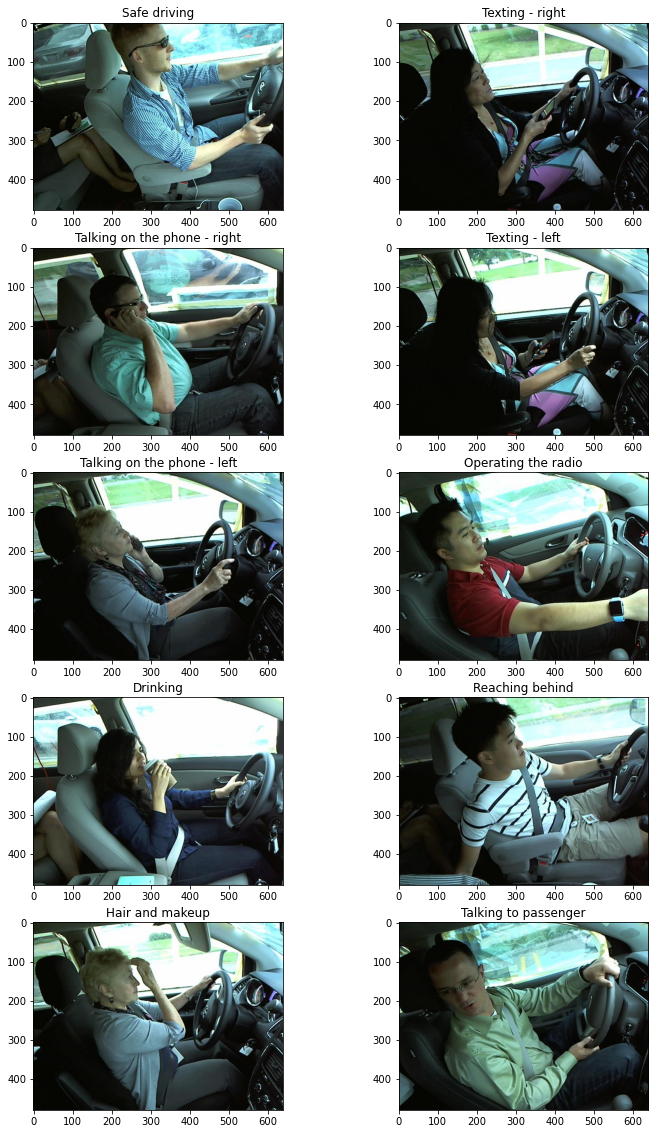

In [9]:
activity_map = {'c0': 'Safe driving',
                'c1': 'Texting - right',
                'c2': 'Talking on the phone - right',
                'c3': 'Texting - left',
                'c4': 'Talking on the phone - left',
                'c5': 'Operating the radio',
                'c6': 'Drinking',
                'c7': 'Reaching behind',
                'c8': 'Hair and makeup',
                'c9': 'Talking to passenger'}

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = 'D:/Kaggle/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(activity_map[directory])

In [10]:
# Number of batch size and epochs
batch_size = 40 #40
nb_epoch = 6 #10

In [11]:
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

checkpointer = ModelCheckpoint(filepath='saved_models/weights_best_vanilla.hdf5',
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)
#callbacks = [checkpointer, es]

In [12]:
def create_model():
    model = Sequential()

    # Batch normalization is a technique for training very deep neural networks that standardizes the inputs to a layer for each mini-batch. This has the effect of stabilizing the learning process and dramatically reducing the number of training epochs required to train deep networks.

    # Dropout is a technique used to prevent a model from overfitting by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

    ## CNN 1
    model.add(Conv2D(32,(3,3),activation='relu',input_shape=(img_rows, img_cols, color_type)))
    model.add(BatchNormalization())
    model.add(Conv2D(32,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 2
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(64,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.3))

    ## CNN 3
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization())
    model.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    model.add(BatchNormalization(axis = 3))
    model.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    model.add(Dropout(0.5))

    ## Output
    model.add(Flatten())
    model.add(Dense(512,activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(128,activation='relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10,activation='softmax'))

    return model

In [1]:
from keras.utils.vis_utils import plot_model

model = create_model()

# More details about the layers
model.summary()
plot_model(model, to_file="model_plot.png", show_shapes=True, show_layer_names=True)

# Compiling the model
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

NameError: name 'create_model' is not defined

In [14]:
history = model.fit(x_train, y_train,
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

#model.load_weights('saved_models/weights_best_vanilla.hdf5')
print('History of the training',history.history)

Epoch 1/6
449/449 [==============================] - 112s 247ms/step - loss: 1.2884 - accuracy: 0.5809 - val_loss: 0.5352 - val_accuracy: 0.8310
Epoch 2/6
449/449 [==============================] - 111s 247ms/step - loss: 0.3683 - accuracy: 0.8815 - val_loss: 0.2081 - val_accuracy: 0.9405
Epoch 3/6
449/449 [==============================] - 111s 247ms/step - loss: 0.2138 - accuracy: 0.9336 - val_loss: 0.0780 - val_accuracy: 0.9784
Epoch 4/6
449/449 [==============================] - 111s 246ms/step - loss: 0.1596 - accuracy: 0.9533 - val_loss: 0.0718 - val_accuracy: 0.9790
Epoch 5/6
449/449 [==============================] - 111s 247ms/step - loss: 0.1263 - accuracy: 0.9620 - val_loss: 0.0710 - val_accuracy: 0.9819
Epoch 6/6
449/449 [==============================] - 111s 247ms/step - loss: 0.1069 - accuracy: 0.9677 - val_loss: 0.0668 - val_accuracy: 0.9828
History of the training {'loss': [1.2884498834609985, 0.368261456489563, 0.21376489102840424, 0.1596221923828125, 0.12634275853633

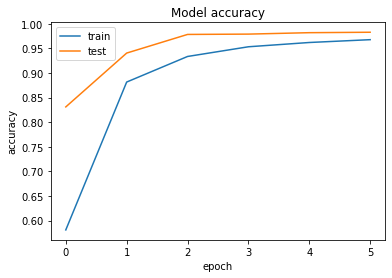

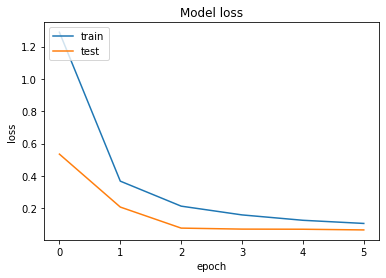

In [15]:
def plot_train_history(history):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

plot_train_history(history)

In [16]:
def plot_test_class(model, test_files, image_number, color_type=1):
    """
    Function that tests or model on test images and show the results
    """
    img_brute = test_files[image_number]
    img_brute = cv2.resize(img_brute,(img_rows,img_cols))
    plt.imshow(img_brute, cmap='gray')

    new_img = img_brute.reshape(-1,img_rows,img_cols,color_type)

    y_prediction = model.predict(new_img, batch_size=batch_size, verbose=1)
    print('Y prediction: {}'.format(y_prediction))
    print('Predicted: {}'.format(activity_map.get('c{}'.format(np.argmax(y_prediction)))))

    plt.show()

In [17]:
score1 = model.evaluate(x_test, y_test, verbose=1)

141/141 [==============================] - 6s 40ms/step - loss: 0.0668 - accuracy: 0.9828


In [18]:
print('Loss: ', score1[0])
print('Accuracy: ', score1[1]*100, ' %')

Loss:  0.06684402376413345
Accuracy:  98.28316569328308  %


1/1 [==============================] - 0s 144ms/step
Y prediction: [[7.7275186e-16 1.8426202e-27 3.6870320e-21 1.5544798e-19 1.4824352e-19
  1.0000000e+00 2.0300842e-21 1.0986343e-20 1.9653476e-18 1.2762062e-13]]
Predicted: Operating the radio


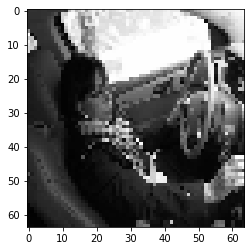

1/1 [==============================] - 0s 16ms/step
Y prediction: [[3.2393790e-13 6.6922602e-22 5.8120419e-18 3.3649871e-16 1.6608649e-13
  1.0000000e+00 2.3139210e-15 8.4018124e-17 1.1208632e-12 3.0214876e-11]]
Predicted: Operating the radio


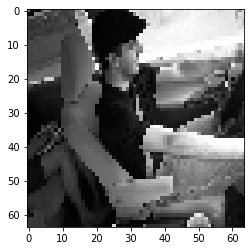

1/1 [==============================] - 0s 17ms/step
Y prediction: [[9.9307066e-01 1.9354456e-03 3.9629100e-04 1.0423123e-04 7.7226653e-04
  2.1583930e-06 1.1861900e-04 1.9114282e-06 3.0942510e-03 5.0412858e-04]]
Predicted: Safe driving


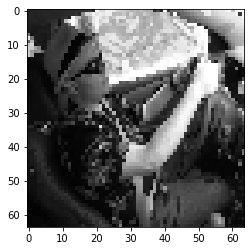

1/1 [==============================] - 0s 16ms/step
Y prediction: [[5.4775351e-03 5.5913780e-08 4.1193329e-03 1.5693780e-09 2.6965961e-06
  1.3406006e-06 9.9640511e-06 2.2336182e-07 9.9025959e-01 1.2925596e-04]]
Predicted: Hair and makeup


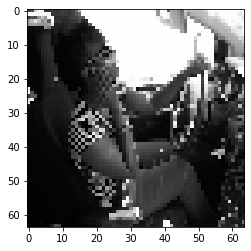

1/1 [==============================] - 0s 16ms/step
Y prediction: [[2.9284982e-05 6.4579224e-11 5.8574610e-11 9.9262565e-01 7.2815007e-04
  1.5833470e-04 2.2673050e-13 1.9442111e-12 5.8419482e-05 6.4001502e-03]]
Predicted: Texting - left


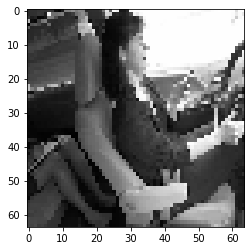

1/1 [==============================] - 0s 16ms/step
Y prediction: [[1.2990979e-08 6.2827725e-12 1.0853580e-12 9.9999928e-01 7.4156742e-07
  4.6522217e-08 6.4788181e-13 9.6551482e-12 2.0086434e-11 1.0151825e-09]]
Predicted: Texting - left


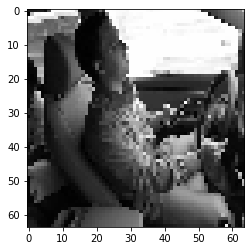

1/1 [==============================] - 0s 16ms/step
Y prediction: [[2.3380653e-03 3.9439408e-05 7.9105070e-07 2.0238320e-05 3.0802625e-05
  7.0254225e-04 1.0596438e-06 5.3288812e-08 3.5488682e-03 9.9331820e-01]]
Predicted: Talking to passenger


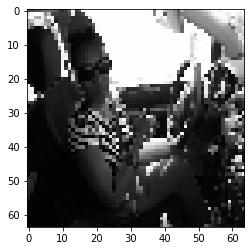

1/1 [==============================] - 0s 16ms/step
Y prediction: [[8.2398242e-01 2.1418089e-03 3.4765273e-04 3.8041867e-02 8.3634257e-04
  7.8244880e-03 3.5722899e-06 7.9695492e-05 4.2895015e-02 8.3847120e-02]]
Predicted: Safe driving


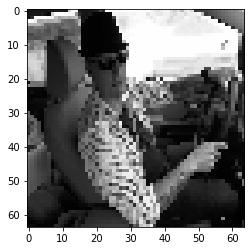

1/1 [==============================] - 0s 16ms/step
Y prediction: [[1.1281772e-09 3.1454658e-08 3.9995266e-03 4.1157111e-13 1.0866843e-06
  4.2847656e-10 9.9599922e-01 2.1799393e-08 2.8065298e-07 4.1988281e-11]]
Predicted: Drinking


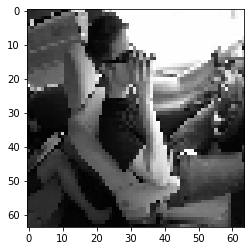

1/1 [==============================] - 0s 17ms/step
Y prediction: [[1.02707877e-10 1.09503215e-08 1.20071023e-10 1.81468162e-13
  2.75763368e-09 4.25016644e-08 3.97751343e-08 9.99999881e-01
  8.87757636e-08 1.51118034e-08]]
Predicted: Reaching behind


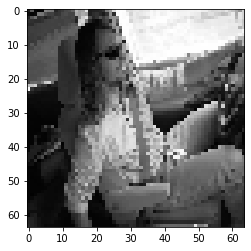

In [19]:
for i in range(10):
    plot_test_class(model, test_files, i)

In [20]:
# Using ImageDataGenerator from keras
train_datagen = ImageDataGenerator(rescale = 1.0/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True,
                                   validation_split = 0.2)

test_datagen = ImageDataGenerator(rescale=1.0/ 255, validation_split = 0.2)

In [21]:
nb_train_samples = x_train.shape[0]
nb_validation_samples = x_test.shape[0]
training_generator = train_datagen.flow(x_train, y_train, batch_size=batch_size)
validation_generator = test_datagen.flow(x_test, y_test, batch_size=batch_size)

In [22]:
#checkpoint = ModelCheckpoint('saved_models/weights_best_vanilla.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v2 = model.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = nb_epoch,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/6
448/448 [==============================] - 112s 249ms/step - loss: 1.2528 - accuracy: 0.6129 - val_loss: 3.4655 - val_accuracy: 0.1176
Epoch 2/6
448/448 [==============================] - 112s 249ms/step - loss: 0.6831 - accuracy: 0.7739 - val_loss: 0.2816 - val_accuracy: 0.9297
Epoch 3/6
448/448 [==============================] - 112s 250ms/step - loss: 0.5352 - accuracy: 0.8297 - val_loss: 0.1213 - val_accuracy: 0.9696
Epoch 4/6
448/448 [==============================] - 111s 248ms/step - loss: 0.4434 - accuracy: 0.8627 - val_loss: 0.1595 - val_accuracy: 0.9609
Epoch 5/6
448/448 [==============================] - 113s 252ms/step - loss: 0.3971 - accuracy: 0.8754 - val_loss: 0.1619 - val_accuracy: 0.9717
Epoch 6/6
448/448 [==============================] - 112s 250ms/step - loss: 0.3655 - accuracy: 0.8886 - val_loss: 0.0926 - val_accuracy: 0.9779


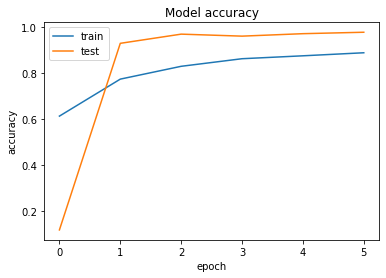

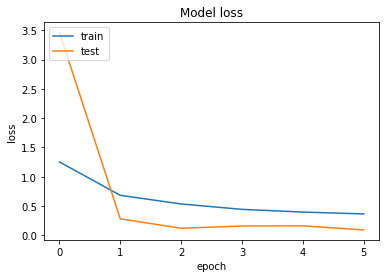

In [23]:
#model2.load_weights('saved_models/weights_best_va nilla.hdf5')
plot_train_history(history_v2)

In [24]:
# Evaluate and compare the performance of the new model
score2 = model.evaluate_generator(validation_generator, nb_validation_samples // batch_size)
print("Loss for model 1",score1[0])
print("Loss for model 2 (data augmentation):", score2[0])

print("Test accuracy for model 1",score1[1])
print("Test accuracy for model 2 (data augmentation):", score2[1])

Loss for model 1 0.06684402376413345
Loss for model 2 (data augmentation): 0.09264445304870605
Test accuracy for model 1 0.9828316569328308
Test accuracy for model 2 (data augmentation): 0.9779017567634583


In [25]:
print(score1[1] - score2[1])

0.004929900169372559


In [32]:
model.save("3-CNN augmented")

INFO:tensorflow:Assets written to: 3-CNN augmented\assets


In [26]:
def vgg_std16_model(img_rows, img_cols, color_type=3):
    """
    Architecture and adaptation of the VGG16 for our project
    """
    nb_classes = 10
    # Remove fully connected layer and replace
    vgg16_model = VGG16(weights="imagenet", include_top=False)
    for layer in vgg16_model.layers:
        layer.trainable = False

    x = vgg16_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    predictions = Dense(nb_classes, activation = 'softmax')(x) # add dense layer with 10 neurons and activation softmax
    model = Model(vgg16_model.input,predictions)
    return model

In [27]:
# Load the VGG16 network
print("Loading network...")
model_vgg16 = vgg_std16_model(img_rows, img_cols)
model_vgg16.summary()
model_vgg16.compile(loss='categorical_crossentropy',
                         optimizer='rmsprop',
                         metrics=['accuracy'])

Loading network...
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, 

In [28]:
training_generator = train_datagen.flow_from_directory('D:/Kaggle/imgs/train',
                                                 target_size = (img_rows, img_cols),
                                                 batch_size = batch_size,
                                                 shuffle=True,
                                                 class_mode='categorical', subset="training")

validation_generator = test_datagen.flow_from_directory('D:/Kaggle/imgs/test',
                                                   target_size = (img_rows, img_cols),
                                                   batch_size = batch_size,
                                                   shuffle=False,
                                                   class_mode='categorical', subset="validation")
nb_train_samples = 17943
nb_validation_samples = 4481

Found 17943 images belonging to 10 classes.
Found 0 images belonging to 0 classes.


In [29]:
epoch=6

In [30]:
# Training the new Model
#checkpoint = ModelCheckpoint('saved_models/weights_best_vgg16.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')
history_v3 = model_vgg16.fit_generator(training_generator,
                         steps_per_epoch = nb_train_samples // batch_size,
                         epochs = epoch,
                         verbose = 1,
                         validation_data = validation_generator,
                         validation_steps = nb_validation_samples // batch_size)

Epoch 1/6
448/448 [==============================] - 110s 244ms/step - loss: 1.6630 - accuracy: 0.4083
Epoch 2/6
448/448 [==============================] - 108s 241ms/step - loss: 1.1883 - accuracy: 0.5868
Epoch 3/6
448/448 [==============================] - 109s 242ms/step - loss: 0.9804 - accuracy: 0.6570
Epoch 4/6
448/448 [==============================] - 110s 245ms/step - loss: 0.8410 - accuracy: 0.7126
Epoch 5/6
448/448 [==============================] - 110s 245ms/step - loss: 0.7351 - accuracy: 0.7504
Epoch 6/6
448/448 [==============================] - 110s 245ms/step - loss: 0.6594 - accuracy: 0.7757


KeyError: 'val_accuracy'

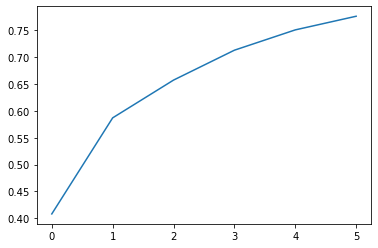

In [31]:
#model_vgg16.load_weights('saved_models/weights_best_vgg16.hdf5')
plot_train_history(history_v3)

In [ ]:
# Evaluate the performance of the new model with Transfer learning
score3 = model_vgg16.evaluate_generator(validation_generator, nb_validation_samples // batch_size, verbose = 1)

print("Test Score with simple CNN:", score1[0])
print("Test Accuracy with simple CNN", score1[1])
print('--------------------------------------')
print("Test Score with Data Augmentation:", score2[0])
print("Test Accuracy with Data Augmentation:", score2[1])
print('--------------------------------------')
print("Test Score with Transfer Learning:", score3[0])
print("Test Accuracy with Transfer Learning:", score3[1])